In [8]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/MyDrive/Phase_Retrieval/Conferencia/utils")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
%tensorflow_version 2.x
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer
from LoadData import *
from AcquisitionLayer import Muestreo
from InitializationLayer import FSI
#from pruebas_layers import LearneableInit
from InitializationUnrolled import InitializationUnrolled
from FinalModel import ProposedModelIterative
from CallBacks import *
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from loss_and_metrics import *
from scipy.io import savemat, loadmat

In [10]:
BATCH_SIZE = 32
dim=(256,256)


DATASET_DIR = "../DATASET"

lista_archivos = [ os.path.join(DATASET_DIR, "TRAIN", archivo) for archivo in os.listdir(os.path.join(DATASET_DIR, "TRAIN"))]
lista_archivos = lista_archivos+ [ os.path.join(DATASET_DIR, "TEST", archivo) for archivo in os.listdir(os.path.join(DATASET_DIR, "TEST"))]
lista_archivos = lista_archivos+ [ os.path.join(DATASET_DIR, "VALIDATION", archivo) for archivo in os.listdir(os.path.join(DATASET_DIR, "VALIDATION"))]

train_files, test_files = train_test_split(lista_archivos,test_size=0.2, random_state=42)
test_files, validation_files = train_test_split(test_files,test_size=0.5, random_state=42)
RESULTS_DIR = "../results"



train_generator = DataGenerator(train_files, batch_size=BATCH_SIZE, dim=dim, shuffle=False)
test_generator = DataGenerator(test_files, batch_size=BATCH_SIZE, dim=dim, shuffle=False)
validation_generator = DataGenerator(validation_files, batch_size=BATCH_SIZE, dim=dim, shuffle=False)
X = validation_generator.__getitem__(0)[0]

In [11]:
batch = train_generator[0]

In [12]:
print(len(train_files))
print(len(test_files))
print(len(validation_files))

1159
145
145


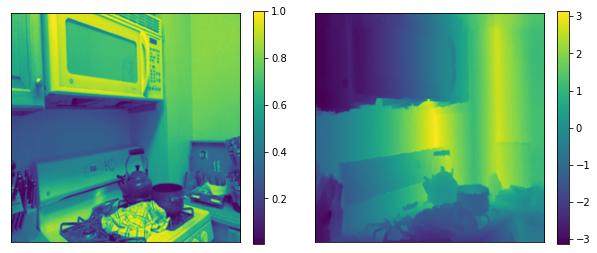

In [13]:
fig, axs = plt.subplots(1, 2,figsize=(10,10))
a = axs[0].imshow(X[0,:,:,0]); plt.sca(axs[0]); plt.yticks([]); plt.xticks([])
fig.colorbar(a, ax=axs[0],fraction=0.046)
a = axs[1].imshow(X[0,:,:,1])
fig.colorbar(a, ax=axs[1],fraction=0.046); plt.sca(axs[1]); plt.yticks([]); plt.xticks([])
#fig.savefig(os.path.join(RESULTS_DIR, "basic", "imagen_real_pesos_aprendidos.svg"))
fig.show()

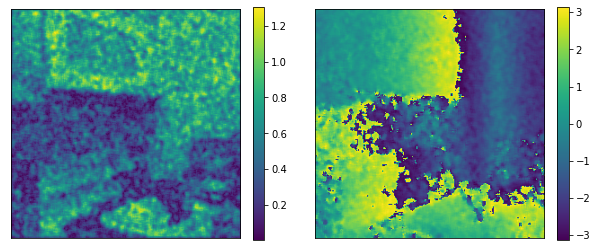

In [14]:
capa_init = FSI(50)

conv_psf, D = Muestreo(1)(X)
inicializacion = capa_init([conv_psf, D])
fig, axs = plt.subplots(1, 2,figsize=(10,10))
a = axs[0].imshow(inicializacion[0,:,:,0]); plt.sca(axs[0]); plt.yticks([]); plt.xticks([])
fig.colorbar(a, ax=axs[0],fraction=0.046)
a = axs[1].imshow(inicializacion[0,:,:,1])
fig.colorbar(a, ax=axs[1],fraction=0.046); plt.sca(axs[1]); plt.yticks([]); plt.xticks([])
fig.show()

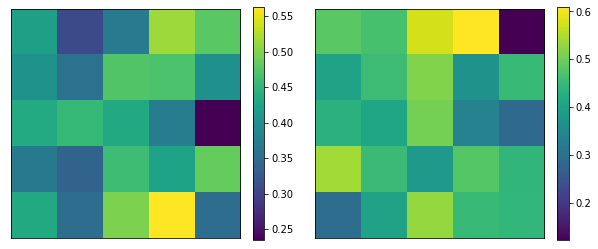

In [15]:
pesos = capa_init.get_weights()
filtro_abs = tf.squeeze(pesos[0])
filtro_ang = tf.squeeze(pesos[1])

fig, axs = plt.subplots(1, 2,figsize=(10,10))
a = axs[0].imshow(filtro_abs); plt.sca(axs[0]); plt.yticks([]); plt.xticks([])
fig.colorbar(a, ax=axs[0],fraction=0.046)
a = axs[1].imshow(filtro_ang)
fig.colorbar(a, ax=axs[1],fraction=0.046); plt.sca(axs[1]); plt.yticks([]); plt.xticks([])
fig.show()

In [16]:
# def get_model(n_power = 50, gene = True, unrolled = False, input_size=(*dim, 2), L = 2, batch_size = BATCH_SIZE):
#   trueImg = tf.keras.Input(shape=input_size, batch_size=batch_size, name='inputs')
#   muestras, codigo = Muestreo(L)(trueImg)

#   if (unrolled):
#     inicializacion = InitializationUnrolled(n_power)([muestras, codigo])
#   else:
#     inicializacion = LearneableInit(n_power)([muestras, codigo])
#   if (gene):
#     salida = get_generador(inicializacion)
#     model = tf.keras.Model(inputs=trueImg, outputs=salida)
#   else:
#     init_amp = tf.gather(inicializacion, indices=0, axis=3, name="Init_Amplitud")
#     init_ang = tf.gather(inicializacion, indices=1, axis=3, name="Init_Angulo")
#     salida = [init_amp , init_ang, init_amp , init_ang]
#     model = tf.keras.Model(inputs=trueImg, outputs=salida)
#   return model

In [17]:
def ignore_loss(y1,y2):
  return 0

def run_train(n_epochs, unrolled, input_shape = (BATCH_SIZE, *(*dim,2)),results_dir = RESULTS_DIR, train_g = None, test_g = None):
  
  if (unrolled):
    type_model = "unrolled"
  else:
    type_model = "basic"

  mse = 'mean_squared_error'
  folder = os.path.join(results_dir, type_model)
  chekpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(folder, type_model+"_last_weights.h5"), save_weights_only=True)
  save_results = SaveResults_CB(folder, generator = test_g, type_model=type_model)


  opti = tf.keras.optimizers.Adam(amsgrad=True, learning_rate=1e-3)
  model = ProposedModelIterative(snapshots=1, n_power=10, use_generator = True)
  model.build(input_shape) 

  model.save_weights(os.path.join(folder, type_model+"_initial_weights.h5"))
  mse = tf.keras.losses.MeanSquaredError()
  #losses = [Loss_Abs, Loss_Ang, Loss_Abs, Loss_Ang,Loss_Abs, Loss_Ang, Loss_Abs, Loss_Ang,Loss_Abs, Loss_Ang]
  #losses = [mse, mse, Loss_Abs, Loss_Ang, mse, mse, mse, mse,mse, mse]
  #losses_w = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
  losses = [mse, mse,mse, mse]
  losses_w = np.array([0.4, 0.4,0.1,0.1])
  model.compile(optimizer=opti, loss=losses, loss_weights=losses_w, run_eagerly=True)
  history = model.fit(train_g, epochs=n_epochs, batch_size=BATCH_SIZE,validation_data=test_g, callbacks=[chekpoint, save_results])
  return model, history


### Reconstrucción Básica

In [18]:
# TRAIN BASIC MODEL
model, history = run_train(250, unrolled=False, results_dir = RESULTS_DIR, train_g = train_generator, test_g = test_generator)

58892288/58889256 [==============================] - 1s 0us/step


KeyboardInterrupt: ignored

In [ ]:
path_toy_obj = os.path.join("../Toy_Object.mat")
X_Test = loadmat(path_toy_obj)["x"]
X_Test = np.expand_dims(X_Test, [0,-1])
X_Test_real = tf.math.abs(X_Test)
X_Test_imag = tf.math.angle(X_Test)
X_Test = tf.concat([X_Test_real, X_Test_imag], -1)
X_Test = tf.image.resize(X_Test, (256,256))


print(X_Test.shape)

In [ ]:
#@title Resultados Reconstrucción Básica
fig, axs = plt.subplots(1, 2,figsize=(10,10))
a = axs[0].imshow(X_Test[0,:,:,0]); plt.sca(axs[0]); plt.yticks([]); plt.xticks([])
fig.colorbar(a, ax=axs[0],fraction=0.046)
a = axs[1].imshow(X_Test[0,:,:,1])
fig.colorbar(a, ax=axs[1],fraction=0.046); plt.sca(axs[1]); plt.yticks([]); plt.xticks([])
fig.show()

X_pred = model.predict(X_Test)

fig, axs = plt.subplots(1, 2,figsize=(10,10))
a = axs[0].imshow(tf.squeeze(X_pred[0])); plt.sca(axs[0]); plt.yticks([]); plt.xticks([])
fig.colorbar(a, ax=axs[0],fraction=0.046)
a = axs[1].imshow(tf.squeeze(X_pred[1]))
fig.colorbar(a, ax=axs[1],fraction=0.046); plt.sca(axs[1]); plt.yticks([]); plt.xticks([])

#fig.savefig(os.path.join(RESULTS_DIR, "basic", "Inicialización_pesos_aprendidos.svg"))
fig.savefig(os.path.join(RESULTS_DIR, "basic", "Reconstrucción_pesos_aprendidos.svg"))
fig.show()



## Reconstrucción Unrolled

In [ ]:
# TRAIN UNROLLED MODEL
#model, history = run_train(100, unrolled=True, results_dir = RESULTS_DIR, train_g = test_generator, test_g = vali_da)

In [ ]:
#@title Resultados Reconstrucción Unrolled

# fig, axs = plt.subplots(1, 2,figsize=(10,10))
# a = axs[0].imshow(X_Test[0,:,:,0]); plt.sca(axs[0]); plt.yticks([]); plt.xticks([])
# fig.colorbar(a, ax=axs[0],fraction=0.046)
# a = axs[1].imshow(X_Test[0,:,:,1])
# fig.colorbar(a, ax=axs[1],fraction=0.046); plt.sca(axs[1]); plt.yticks([]); plt.xticks([])
# fig.show()


# X_pred = model.predict(X_Test)
# #X_pred = X_pred[0]
# fig, axs = plt.subplots(1, 2,figsize=(10,10))
# a = axs[0].imshow(X_pred[2][0,:,:]); plt.sca(axs[0]); plt.yticks([]); plt.xticks([])
# fig.colorbar(a, ax=axs[0],fraction=0.046)
# a = axs[1].imshow(X_pred[3][0,:,:])
# fig.colorbar(a, ax=axs[1],fraction=0.046); plt.sca(axs[1]); plt.yticks([]); plt.xticks([])
# fig.show()

## Resultados Inicializaciones

In [ ]:

X_Test = X#train_generator.__getitem__(7)[0]

In [ ]:
BATCH_SIZE = 32
input_size=(256,256,2)

In [ ]:
model_basic = ProposedModelIterative(snapshots=1, n_power=10, use_generator = True)
model_basic.build((BATCH_SIZE, *input_size)) 
model_basic.load_weights(os.path.join(RESULTS_DIR, "basic", "basic_last_weights.h5"))

In [ ]:
l = 11

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(10,10))
a = axs[0].imshow(X_Test[l,:,:,0]); plt.sca(axs[0]); plt.yticks([]); plt.xticks([])
fig.colorbar(a, ax=axs[0],fraction=0.046)
a = axs[1].imshow(X_Test[l,:,:,1])
fig.colorbar(a, ax=axs[1],fraction=0.046); plt.sca(axs[1]); plt.yticks([]); plt.xticks([])
#fig.savefig(os.path.join(RESULTS_DIR, "basic", "imagen_real_pesos_aprendidos.svg"))
fig.show()

In [ ]:
type([0][0][0])

In [ ]:
dict_x_test = {"x_test":X_Test[l,:,:,:].numpy().tolist()}

savemat(os.path.join(RESULTS_DIR, "basic", "x_test_original.mat"), dict_x_test)

In [ ]:
X_pred = model_basic.predict(X_Test)
#print(len(X_pred))
fig, axs = plt.subplots(1, 2,figsize=(10,10))
a = axs[0].imshow(tf.squeeze(X_pred[2][l])); plt.sca(axs[0]); plt.yticks([]); plt.xticks([])
fig.colorbar(a, ax=axs[0],fraction=0.046)
a = axs[1].imshow(tf.squeeze(X_pred[3][l]))
fig.colorbar(a, ax=axs[1],fraction=0.046); plt.sca(axs[1]); plt.yticks([]); plt.xticks([])

#fig.savefig(os.path.join(RESULTS_DIR, "basic", "Inicialización_pesos_aprendidos.svg"))
#fig.savefig(os.path.join(RESULTS_DIR, "basic", "Reconstrucción_pesos_aprendidos.svg"))
fig.show()

dict_x_test = {"x_pred_abs":X_pred[2][l].tolist(),
               "x_pred_ang":X_pred[3][l].tolist()}

savemat(os.path.join(RESULTS_DIR, "basic", "x_test_final.mat"), dict_x_test)

In [ ]:
pesos = model_basic.layers[1].get_weights()

filtro_real = tf.squeeze(pesos[0])
filtro_imag = tf.squeeze(pesos[1])

fig, axs = plt.subplots(1, 2,figsize=(10,10))
a = axs[0].imshow(filtro_real); plt.sca(axs[0]); plt.yticks([]); plt.xticks([])
fig.colorbar(a, ax=axs[0],fraction=0.046)
a = axs[1].imshow(filtro_imag)
fig.colorbar(a, ax=axs[1],fraction=0.046); plt.sca(axs[1]); plt.yticks([]); plt.xticks([])
fig.savefig(os.path.join(RESULTS_DIR, "basic", "KErnels_entrenados.svg"))
fig.show()



In [ ]:
dict_kernel = {"kernel_real":filtro_real.numpy().tolist(),
               "kernel_imag":filtro_imag.numpy().tolist()}

savemat(os.path.join(RESULTS_DIR, "basic", "Kernerls_Entrenados.mat"), dict_kernel)

In [ ]:
model_basic_initial = ProposedModelIterative(snapshots=1, n_power=200, use_generator = True)
model_basic_initial.build((BATCH_SIZE, *input_size)) 
model_basic_initial.load_weights(os.path.join(RESULTS_DIR, "basic", "basic_initial_weights.h5"))

In [ ]:

X_pred = model_basic_initial.predict(X_Test)

fig, axs = plt.subplots(1, 2,figsize=(10,10))
a = axs[0].imshow(X_pred[2][0,:,:]); plt.sca(axs[0]); plt.yticks([]); plt.xticks([])
fig.colorbar(a, ax=axs[0],fraction=0.046)
a = axs[1].imshow(X_pred[3][0,:,:])
fig.colorbar(a, ax=axs[1],fraction=0.046); plt.sca(axs[1]); plt.yticks([]); plt.xticks([])
#fig.savefig(os.path.join(RESULTS_DIR, "basic", "Resultado PESOS Iniciales200 power it"))
fig.show()

In [ ]:
pesos = model_basic_initial.layers[1].get_weights()
filtro_abs = tf.squeeze(pesos[0])
filtro_ang = tf.squeeze(pesos[1])
fig, axs = plt.subplots(1, 2,figsize=(10,10))
a = axs[0].imshow(filtro_abs); plt.sca(axs[0]); plt.yticks([]); plt.xticks([])
fig.colorbar(a, ax=axs[0],fraction=0.046)
a = axs[1].imshow(filtro_ang)
fig.colorbar(a, ax=axs[1],fraction=0.046); plt.sca(axs[1]); plt.yticks([]); plt.xticks([])
#fig.savefig(os.path.join(RESULTS_DIR, "basic", "Pesos iniciales 200 power it"))
fig.show()